# Aktuelle Limitierungen:

* Inhalte, die mehreren Fächern zugeordnet worden sind, zählen nur zu einem Fach
* Es werden nur Bearbeitungen gezählt
* Folgeevents einer Bearbeitung werden nicht zusammengefasst

In [1]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown, HTML

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

#display(getSubjectFromUuid(127338))
#display(getSubjectFromUuid(63496))
#display(getSubjectFromUuid(1))
#display(getSubjectFromUuid(170741))
#display(getSubjectFromUuid(167497))

/Users/cj/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import json

json.dumps(querySingleton("""
select distinct(entity_link.parent_id ) from event_log join entity_link on entity_link.child_id = event_log.uuid_id where event_log.event_id = 4 and event_log.date > Date("2020-02-01");
"""));

In [3]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(100)

,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
...,...,...,...,...,...
252503,121732,2019-01-04 16:48:53,Jonathan,127576,Mathe
252505,121732,2019-01-04 16:49:01,Jonathan,127602,Mathe
252510,95854,2019-01-04 16:50:43,markus_janker,127600,Chemie


In [22]:
#Activation Rate pro Fach

def calc_activation_rates(days, edits):
    subject_list = list(filter(None, list(event_log['subject'].unique())))
    rates_df = pd.DataFrame(columns = ['subject', 'activation_rate', 'loss_rate'])

    for subject in subject_list:
        between_df = pd.DataFrame()
        activation_rate = int()
        loss_rate = int()
        for month in range(0,2):

            lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + month*30)
            upper_date = pd.Timestamp.today() - pd.Timedelta(days = month*30)
            df1 = pd.DataFrame()
            df2 = pd.DataFrame()
            df3 = pd.DataFrame()
            df4 = pd.DataFrame()

            df1 = event_log[lower_date < event_log['date']] 
            df2 = df1[df1['date'] < upper_date]
            df3 = df2[df2['subject'] == subject]
            df4 = df3.groupby(by = ['actor_id', 'username', 'subject'], as_index = False).count()
            df4['isActive'] = df4['uuid'].apply(lambda x: 1 if x >= edits else 0)

            if between_df.empty:
                between_df = df4
            else:
                between_df = pd.merge(between_df, df4[['actor_id', 'isActive']], on=["actor_id"])

        if not between_df.empty and 'isActive_x' in between_df.columns and 'isActive_y' in between_df.columns:
            between_df['change'] = between_df['isActive_x'] - between_df['isActive_y']
            activation_rate = between_df['change'][between_df['change']>0].sum() / len(between_df)
            loss_rate = between_df['change'][between_df['change']<0].sum() / len(between_df)
        else:
            continue
        append_srs = pd.Series([subject, round(activation_rate,2), round(loss_rate, 2)], index = rates_df.columns)
        rates_df = rates_df.append(append_srs, ignore_index=True)
    return rates_df
        

In [19]:
display(Markdown(f"### Aktivierungsrate pro Fach: Aktive Autorinnen"))
display(Markdown(f"Edits: 10, im Zeitraum: Letzte 90 Tage"))
calc_activation_rates(days=90, edits=10)

### Aktivierungsrate pro Fach: Aktive Autorinnen

Edits: 10, im Zeitraum: Letzte 90 Tage

,subject,activation_rate,loss_rate
0,Chemie,0.00,0.00
1,Mathe,0.05,-0.05
2,Sandkasten,0.05,-0.10
3,Englisch,0.00,0.00
4,Nachhaltigkeit,0.10,-0.10
5,Community,0.00,-0.12
6,Physik,0.00,0.00
7,Prüfungsbereich Mathematik,0.09,-0.09
8,Lerntipps,0.00,-0.25
9,Informatik,0.00,0.00


In [21]:
display(Markdown(f"### Aktivierungsrate pro Fach: Mittelaktive Autorinnen"))
display(Markdown(f"Edits: 50, im Zeitraum: Letzte 90 Tage"))
calc_activation_rates(days=90, edits=50)

### Aktivierungsrate pro Fach: Mittelaktive Autorinnen

Edits: 50, im Zeitraum: Letzte 90 Tage

,subject,activation_rate,loss_rate
0,Chemie,0.00,0.00
1,Mathe,0.10,-0.05
2,Sandkasten,0.00,0.00
3,Englisch,0.00,-0.25
4,Nachhaltigkeit,0.00,0.00
5,Community,0.00,0.00
6,Physik,0.00,0.00
7,Prüfungsbereich Mathematik,0.09,0.00
8,Lerntipps,0.00,0.00
9,Informatik,0.10,0.00


In [23]:
#Activation Rate über alle Fächer hinweg

def calc_act_rates_wo_subj(days, edits):
    result_df = pd.DataFrame()

    for month in range(0,2):

        lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + month*30)
        upper_date = pd.Timestamp.today() - pd.Timedelta(days = month*30)
        df1 = pd.DataFrame()
        df2 = pd.DataFrame()
        df3 = pd.DataFrame()

        df1 = event_log[lower_date < event_log['date']] 
        df2 = df1[df1['date'] < upper_date]
        df3 = df2.groupby(by = ['actor_id', 'username'], as_index = False).count()
        df3['isActive'] = df3['uuid'].apply(lambda x: 1 if x >= edits else 0)

        if result_df.empty:
            result_df = df3
        else:
            result_df = pd.merge(result_df, df3[['actor_id', 'isActive']], on=["actor_id"])

    if not result_df.empty and 'isActive_x' in between_df.columns and 'isActive_y' in between_df.columns:
        result_df['change'] = result_df['isActive_x'] - result_df['isActive_y']
        activation_rate = result_df['change'][result_df['change']>0].sum() / len(result_df)
        loss_rate = result_df['change'][result_df['change']<0].sum() / len(result_df)
        
    return activation_rate, loss_rate

In [26]:
display(Markdown(f"### Aktivierungsrate Fächerübergreifend: Aktive Autorinnen"))
display(Markdown(f"Edits: 10, im Zeitraum: Letzte 90 Tage"))
display(Markdown(f"Aktivierungsrate: {round(calc_act_rates_wo_subj(90, 10)[0], 2)}"))
display(Markdown(f"Verlustrate: {round(calc_act_rates_wo_subj(90, 10)[1], 2)}"))
display(Markdown(f"Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können"))

### Aktivierungsrate Fächerübergreifend: Aktive Autorinnen

Edits: 10, im Zeitraum: Letzte 90 Tage

Aktivierungsrate: 0.04

Verlustrate: -0.06

Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können

In [27]:
display(Markdown(f"### Aktivierungsrate Fächerübergreifend: Aktive Autorinnen"))
display(Markdown(f"Edits: 50, im Zeitraum: Letzte 90 Tage"))
display(Markdown(f"Aktivierungsrate: {round(calc_act_rates_wo_subj(90, 50)[0], 2)}"))
display(Markdown(f"Verlustrate: {round(calc_act_rates_wo_subj(90, 50)[1], 2)}"))
display(Markdown(f"Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können"))

### Aktivierungsrate Fächerübergreifend: Aktive Autorinnen

Edits: 50, im Zeitraum: Letzte 90 Tage

Aktivierungsrate: 0.02

Verlustrate: -0.02

Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können

In [8]:
import matplotlib.pyplot as plt

def show(subject=None, lower=10, time_interval=90):
    df = event_log.copy()
    
    if subject:
        df = df[df["subject"] == subject]
        if len(df) == 0:
            return
        
    edits_per_day = compute_edits_per_day_per_user(df)
    df = edits_per_day.rolling(time_interval, min_periods=time_interval).sum()
    df.dropna(inplace=True)
    
    display(Markdown(f"### Plot Anzahl Autor:innen mit Edits >= {lower}"))
    df.apply(lambda x: x.map(lambda y: y >= lower).sum(), axis=1).plot(figsize=(10,10))
    plt.show()
    
    df2 = pd.DataFrame({
        "edits": df.loc[df.index[-1]],
        "edits_before": df.loc[df.index[-1-time_interval]],
    })
    
    count = (df2["edits"] >= lower).sum()
    
    display(Markdown(f"Anzahl Autor:innen mit Edits >= {lower}: {count}"))
    
    display(Markdown(f"### Autor:innen mit aktuellen Edits >= {lower}"))
    d = df2[df2["edits"] >= lower][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Verlorene Autor:innen mit aktuellen Edits < {lower} und vorher Edits >= {lower}"))
    d = df2[(df2["edits"] < lower) & (df2["edits_before"] >= lower)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind)"))
    df3 = edits_per_day.cumsum()
    df3 = pd.DataFrame({
        "edits": df3.loc[df.index[-1]],
        "edits_before": df3.loc[df.index[-1-time_interval]],
    })
    d = df3[(df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind) + Edits < {lower}"))
    d = df3[(df3["edits"] < lower) & (df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)

def compute_edits_per_day_per_user(df, since=4*365.25):
    current_date = df["date"].max()     # This should probably be set to today!
    df = df[df["date"] > current_date - pd.Timedelta(days=since)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

#show()

### Plot Anzahl Autor:innen mit Edits >= 10

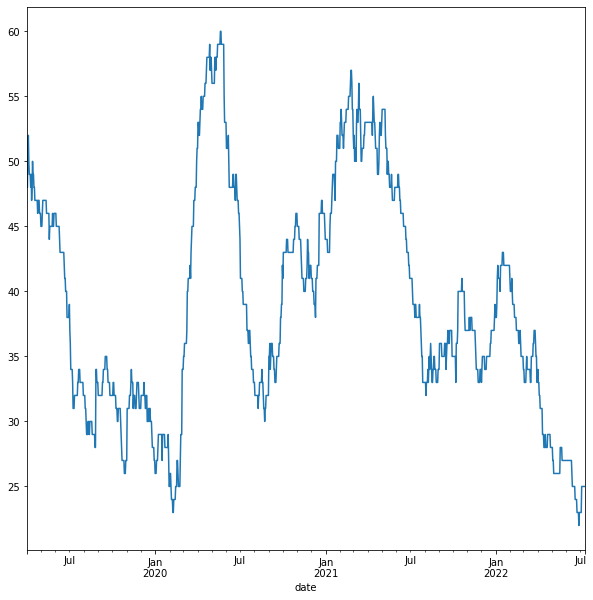

Anzahl Autor:innen mit Edits >= 10: 25

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,825.0
Kowalsky,523.0
LinaMaria,487.0
Karin,477.0
metzgaria,189.0
botho,166.0
kathongi,152.0
Selin_11,144.0
Annika-Hemlein,120.0
Hersheysoldier,100.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
dal,5.0
tamara_proebster,5.0
hwlang,3.0
Astor,0.0
Sascha_Lill_95,0.0
wendrock,0.0
Habiba,0.0
Flo123,0.0
uebermario,0.0
korbi_d,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Parththi,74.0
Katherin,39.0
Lilith_Diringer,36.0
katharina_hauck,10.0
matheprofi123,8.0
rabaer95,5.0
MelanieKop,4.0
nicohue,4.0
tvetter17,4.0
Ramanujan,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
matheprofi123,8.0
rabaer95,5.0
nicohue,4.0
tvetter17,4.0
MelanieKop,4.0
Almut,2.0
Alisa13,2.0
Noravschenck,2.0
Ramanujan,2.0
janice,1.0


In [9]:
show()

### Plot Anzahl Autor:innen mit Edits >= 100

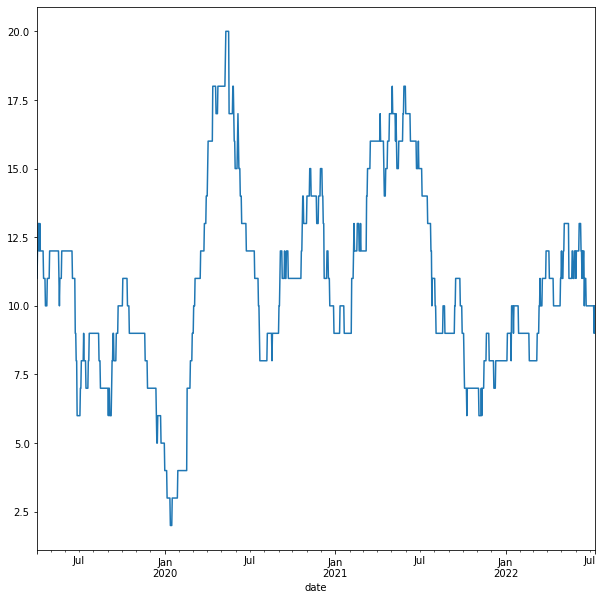

Anzahl Autor:innen mit Edits >= 100: 10

### Autor:innen mit aktuellen Edits >= 100

,edits
Felix_Eccardt,825.0
Kowalsky,523.0
LinaMaria,487.0
Karin,477.0
metzgaria,189.0
botho,166.0
kathongi,152.0
Selin_11,144.0
Annika-Hemlein,120.0
Hersheysoldier,100.0


### Verlorene Autor:innen mit aktuellen Edits < 100 und vorher Edits >= 100

,edits
Peter,77.0
Sascha_Lill_95,0.0
Habiba,0.0
korbi_d,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Parththi,74.0
Katherin,39.0
Lilith_Diringer,36.0
katharina_hauck,10.0
matheprofi123,8.0
rabaer95,5.0
MelanieKop,4.0
nicohue,4.0
tvetter17,4.0
Ramanujan,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 100

,edits
Parththi,74.0
Katherin,39.0
Lilith_Diringer,36.0
katharina_hauck,10.0
matheprofi123,8.0
rabaer95,5.0
MelanieKop,4.0
nicohue,4.0
tvetter17,4.0
Ramanujan,2.0


In [10]:
show(lower=100)

### Plot Anzahl Autor:innen mit Edits >= 50

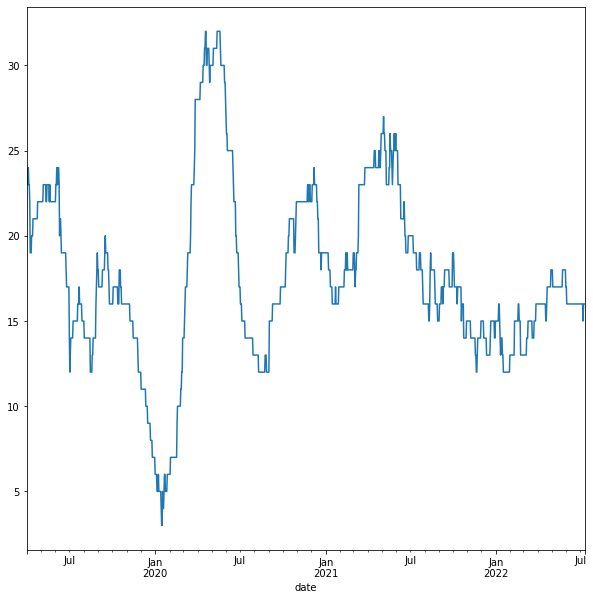

Anzahl Autor:innen mit Edits >= 50: 16

### Autor:innen mit aktuellen Edits >= 50

,edits
Felix_Eccardt,825.0
Kowalsky,523.0
LinaMaria,487.0
Karin,477.0
metzgaria,189.0
botho,166.0
kathongi,152.0
Selin_11,144.0
Annika-Hemlein,120.0
Hersheysoldier,100.0


### Verlorene Autor:innen mit aktuellen Edits < 50 und vorher Edits >= 50

,edits
tamara_proebster,5.0
hwlang,3.0
Sascha_Lill_95,0.0
Habiba,0.0
korbi_d,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Parththi,74.0
Katherin,39.0
Lilith_Diringer,36.0
katharina_hauck,10.0
matheprofi123,8.0
rabaer95,5.0
MelanieKop,4.0
nicohue,4.0
tvetter17,4.0
Ramanujan,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 50

,edits
Katherin,39.0
Lilith_Diringer,36.0
katharina_hauck,10.0
matheprofi123,8.0
rabaer95,5.0
nicohue,4.0
tvetter17,4.0
MelanieKop,4.0
Almut,2.0
Alisa13,2.0


In [11]:
show(lower=50)

In [12]:
event_log["subject"].unique()

array(['Chemie', None, 'Mathe', 'Sandkasten', 'Englisch',
       'Nachhaltigkeit', 'Community', 'Physik',
       'Prüfungsbereich Mathematik', 'Lerntipps', 'Informatik',
       'Deutsch als Zweit- und Fremdsprache', 'Biologie',
       'FÃ¤cher im Aufbau', 'Kommunikation', 'Math', 'Wirtschaft',
       'Geschichte', 'Psychologie', 'Politik', 'mathÃ©matiques',
       'Geographie', 'à®\x87à®²à®\x95à¯\x8dà®\x95à®£à®®à¯\x8d',
       'Medienbildung', 'Testbereich', 'Latein', 'à®µà®°à®²à®¾à®±à¯\x81',
       'Deutsch als Fremdsprache', 'MatemÃ¡ticas',
       'Conseils pour apprendre', 'Sostenibilidad aplicada',
       'Sex Education', 'Musik', 'Estudios en DiÃ¡sporas Africanas',
       'Forensik', 'Italienisch', 'community', 'Deutsch', 'FranzÃ¶sisch',
       'Spanisch', 'Religion'], dtype=object)

## Fach: Mathe

### Plot Anzahl Autor:innen mit Edits >= 10

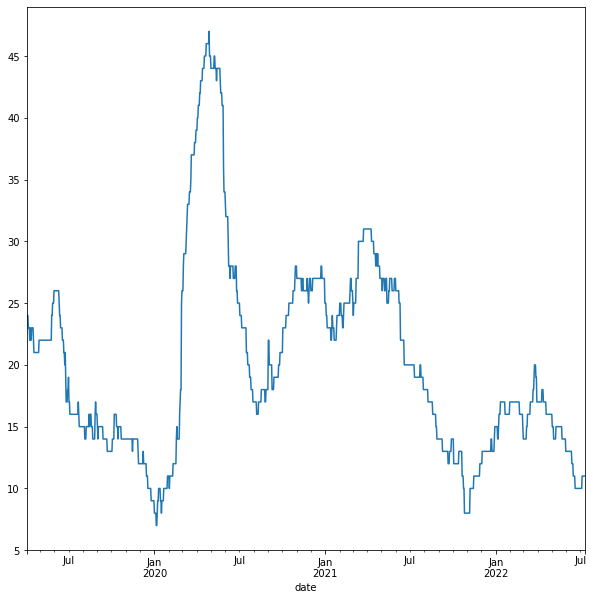

Anzahl Autor:innen mit Edits >= 10: 11

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,472.0
Karin,440.0
Kowalsky,190.0
Hersheysoldier,91.0
kathongi,58.0
Peter,57.0
Annika-Hemlein,51.0
Adonis,32.0
metzgaria,26.0
ClaudiaR,16.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
tamara_proebster,5.0
hwlang,0.0
Sascha_Lill_95,0.0
wendrock,0.0
Habiba,0.0
korbi_d,0.0
Flo123,0.0
Selin_11,0.0
ridaazad384d,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
katharina_hauck,10.0
matheprofi123,8.0
nicohue,4.0
janice,1.0
maetti,1.0
operationjonas,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
matheprofi123,8.0
nicohue,4.0
janice,1.0
maetti,1.0
operationjonas,1.0


## Fach: Chemie

### Plot Anzahl Autor:innen mit Edits >= 10

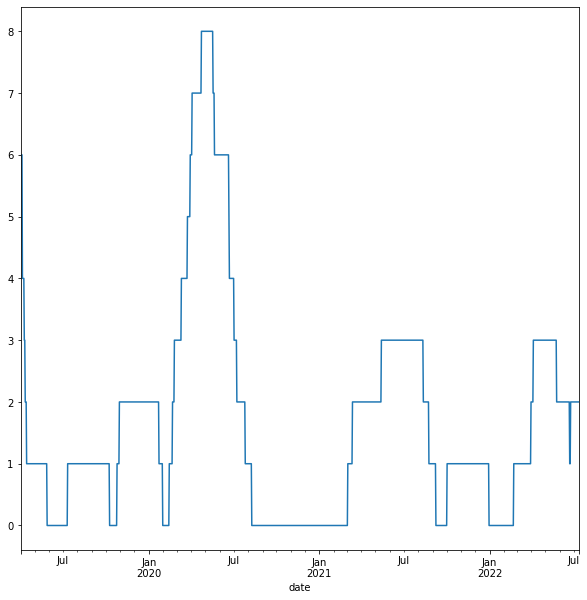

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,44.0
bchij,18.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Corinna,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
MelanieKop,4.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
MelanieKop,4.0


## Fach: Physik

### Plot Anzahl Autor:innen mit Edits >= 10

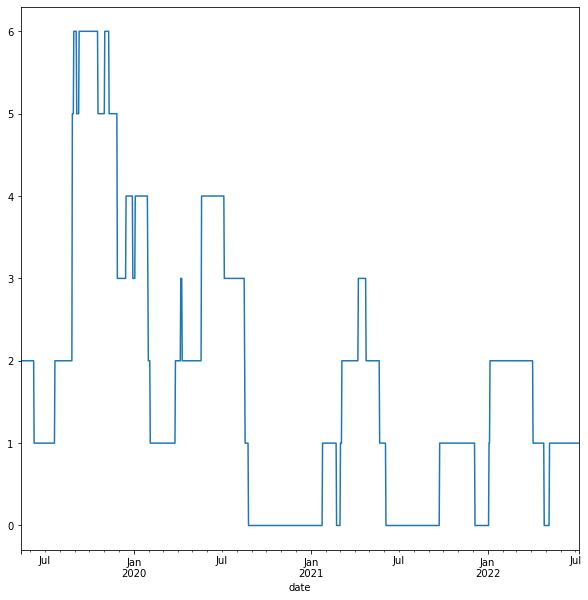

Anzahl Autor:innen mit Edits >= 10: 1

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,20.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
uebermario,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Felix_Eccardt,20.0
Corinna,4.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Corinna,4.0


## Fach: Nachhaltigkeit

### Plot Anzahl Autor:innen mit Edits >= 10

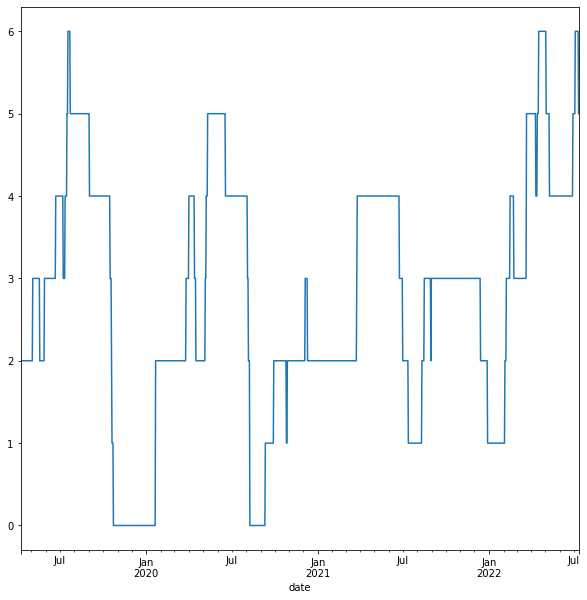

Anzahl Autor:innen mit Edits >= 10: 5

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,42.0
Lilith_Diringer,36.0
botho,27.0
Corinna,20.0
Muutos,14.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Annika-Hemlein,9.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Lilith_Diringer,36.0
anne22,5.0
JessiLo,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
anne22,5.0
JessiLo,1.0


## Fach: Biologie

### Plot Anzahl Autor:innen mit Edits >= 10

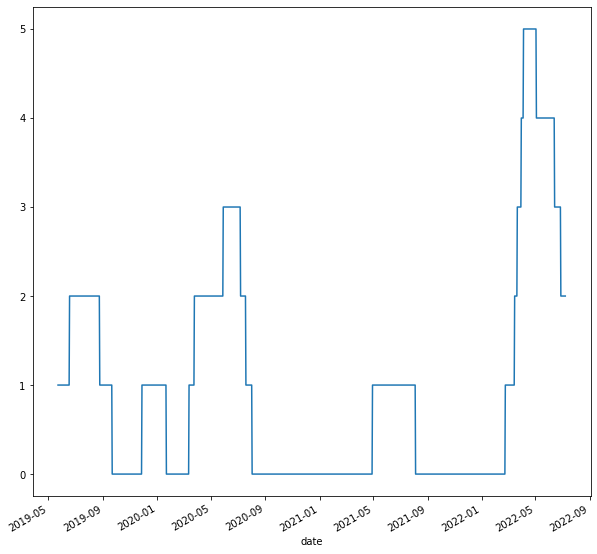

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,74.0
Annika-Hemlein,23.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
kathongi,3.0
Selin_11,0.0
Corinna,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Peter,1.0
ClaudiaR,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Peter,1.0
ClaudiaR,1.0


## Fach: Sandkasten

### Plot Anzahl Autor:innen mit Edits >= 10

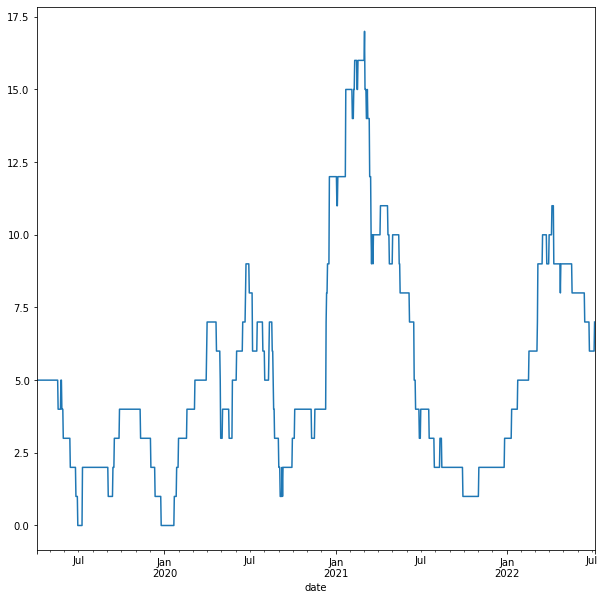

Anzahl Autor:innen mit Edits >= 10: 7

### Autor:innen mit aktuellen Edits >= 10

,edits
Kowalsky,163.0
RalfReinecke,83.0
metzgaria,42.0
LucaWellhausen,28.0
Felix_Eccardt,16.0
Selin_11,13.0
ClaudiaR,10.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
kathongi,8.0
botho,8.0
Peter,2.0
Kaje,0.0
korbi_d,0.0
hwlang,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
rabaer95,5.0
tvetter17,4.0
Annika-Hemlein,4.0
Alisa13,2.0
Noravschenck,2.0
CarolinJaser,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
rabaer95,5.0
tvetter17,4.0
Annika-Hemlein,4.0
Alisa13,2.0
Noravschenck,2.0
CarolinJaser,1.0


## Fach: Prüfungsbereich Mathematik

### Plot Anzahl Autor:innen mit Edits >= 10

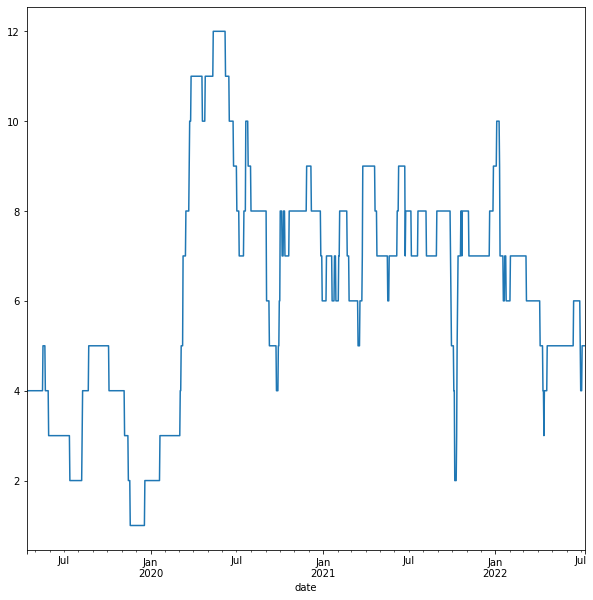

Anzahl Autor:innen mit Edits >= 10: 5

### Autor:innen mit aktuellen Edits >= 10

,edits
Kowalsky,170.0
Karin,32.0
metzgaria,29.0
MGoeldner,20.0
Peter,12.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Hersheysoldier,4.0
Astor,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Felix_Eccardt,9.0
Knorrke,4.0
botho,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Felix_Eccardt,9.0
Knorrke,4.0
botho,1.0


## Fach: Geographie

### Plot Anzahl Autor:innen mit Edits >= 10

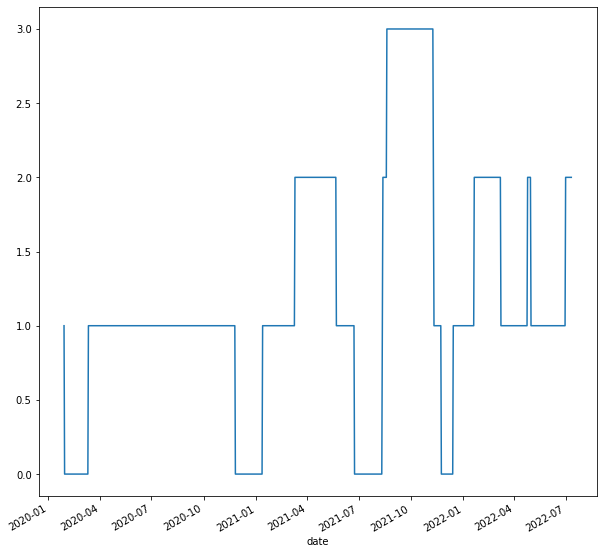

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit aktuellen Edits >= 10

,edits
Selin_11,36.0
Felix_Eccardt,24.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
kathongi,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Selin_11,36.0
Felix_Eccardt,24.0
Vanessa_Brighina,7.0
botho,2.0
Corinna,2.0
ClaudiaR,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Vanessa_Brighina,7.0
botho,2.0
Corinna,2.0
ClaudiaR,1.0


## Fach: Geschichte

### Plot Anzahl Autor:innen mit Edits >= 10

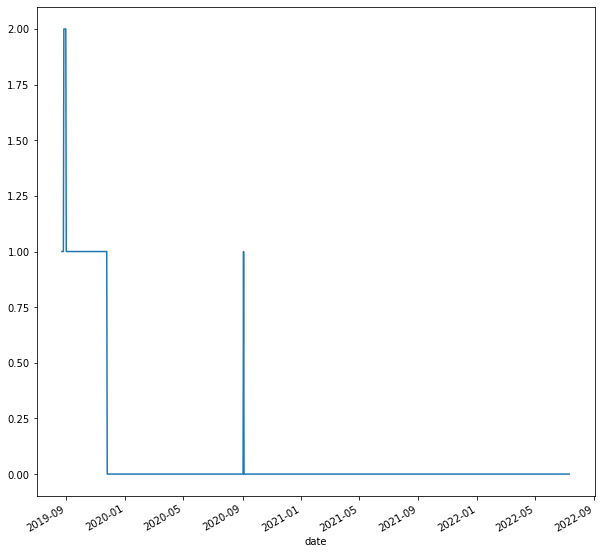

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Carina_Faude,2.0
Felix_Eccardt,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Carina_Faude,2.0
Felix_Eccardt,2.0


## Fach: Community

### Plot Anzahl Autor:innen mit Edits >= 10

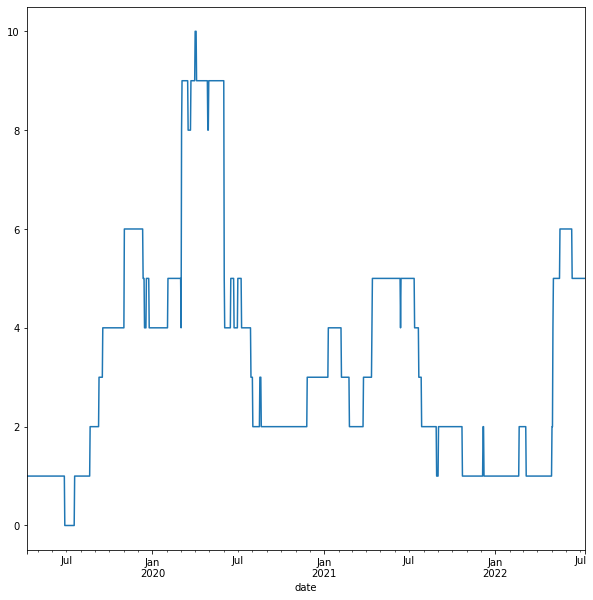

Anzahl Autor:innen mit Edits >= 10: 5

### Autor:innen mit aktuellen Edits >= 10

,edits
LinaMaria,120.0
Katherin,39.0
metzgaria,29.0
anne22,22.0
Corinna,11.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Katherin,39.0
Felix_Eccardt,3.0
CarolinJaser,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Felix_Eccardt,3.0
CarolinJaser,2.0


## Fach: Informatik

### Plot Anzahl Autor:innen mit Edits >= 10

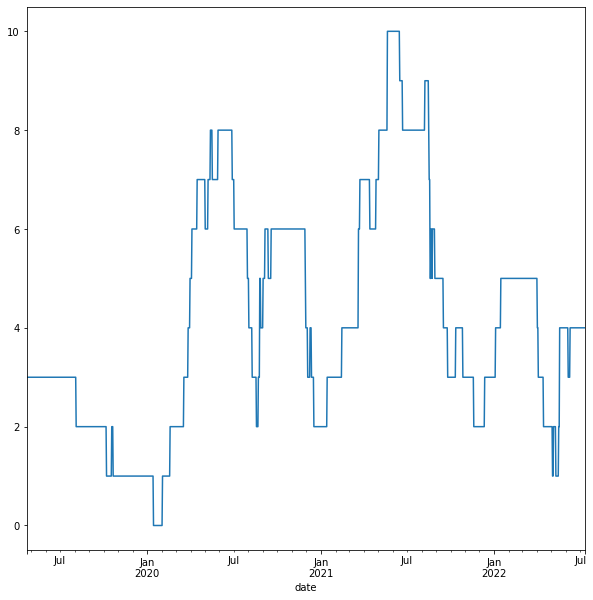

Anzahl Autor:innen mit Edits >= 10: 4

### Autor:innen mit aktuellen Edits >= 10

,edits
Felix_Eccardt,76.0
Parththi,74.0
Adonis,58.0
metzgaria,54.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
ClaudiaR,5.0
hwlang,3.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Parththi,74.0
Ramanujan,2.0
botho,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Ramanujan,2.0
botho,1.0


## Fach: Englisch

### Plot Anzahl Autor:innen mit Edits >= 10

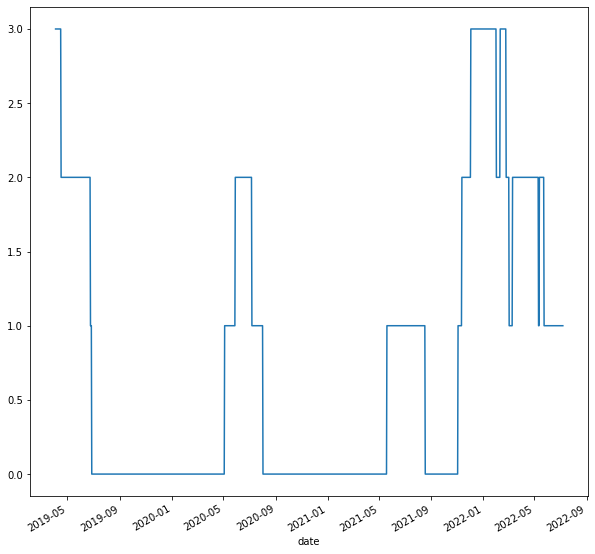

Anzahl Autor:innen mit Edits >= 10: 1

### Autor:innen mit aktuellen Edits >= 10

,edits
Selin_11,44.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Annika-Hemlein,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Peter,1.0
ClaudiaR,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Peter,1.0
ClaudiaR,1.0


In [13]:
for subject in ["Mathe", "Chemie", "Physik",
                  "Nachhaltigkeit", "Biologie", "Sandkasten", "Prüfungsbereich Mathematik",
               "Geographie", "Geschichte", "Community", "Informatik", "Englisch"]:
    
    display(Markdown(f"## Fach: {subject}"))
    show(subject=subject)

In [14]:
def show_no_authors():
    def current_no_authors(d):
        return d[pd.Timestamp.today() - d["date"] < pd.Timedelta("90 days")]["username"].nunique()
    
    def last_year_no_authors(d):
        return d[
            (d["date"] < pd.Timestamp.today() - pd.Timedelta("365 days")) &
            (d["date"] > pd.Timestamp.today() - pd.Timedelta("455 days"))
        ]["username"].nunique()
    
    return event_log.groupby("subject").apply(lambda d: pd.Series({
        "current no authors": current_no_authors(d),
        "last year no authors": last_year_no_authors(d)
    }))

show_no_authors()

,current no authors,last year no authors
subject,,
Biologie,7,4
Chemie,8,6
Community,11,12
Conseils pour apprendre,0,1
Deutsch,2,2
Deutsch als Fremdsprache,2,1
Deutsch als Zweit- und Fremdsprache,1,0
Englisch,6,2
Estudios en DiÃ¡sporas Africanas,1,1
